In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import joblib
import os
import numpy as np

In [2]:
import os
import sys
# Get the path to the current directory of the script
bins_path = "/Users/jzeng63/Desktop/CDNA/ML/HMM/TS/Bins"
sys.path.append(bins_path)

In [3]:
import utility

In [4]:
utility._prepare_training(data_path = '../../../Data_processing/Outputs/train.csv', features = ['aval_AlloMap',  'aval_AlloSure', 'ady_dna'], exclusion = True, split = 0.8, patient_level = True)

,usubjid,ady_dna,avisitn,aval_AlloMap,aval_AlloSure,label
111,CDNA-SN-C-00011-S01-010,73,60,30.0,0.060403,0.0
112,CDNA-SN-C-00011-S01-010,88,91,25.0,0.036974,0.0
113,CDNA-SN-C-00011-S01-010,116,121,26.0,0.045695,0.0
114,CDNA-SN-C-00011-S01-010,144,182,28.0,0.020336,0.0
115,CDNA-SN-C-00011-S01-010,159,182,34.0,0.016161,0.0
...,...,...,...,...,...,...
26134,CDNA-SN-C-00011-S66-011,857,821,32.0,0.210610,0.0
26135,CDNA-SN-C-00011-S66-011,945,912,32.0,0.869300,0.0
26336,CDNA-SN-C-00011-S67-001,150,182,27.0,0.082151,1.0
26371,CDNA-SN-C-00011-S67-006,427,456,34.0,0.055184,1.0


# Load models

In [5]:
model_directory = "../models"
model_name = "80%train_50iter_commetrics_patient_level_55_partial.pkl"
model_path = os.path.join(model_directory, model_name)

# Load the model from the file
kf = joblib.load(model_path)

# inference future

# load data

In [6]:

# Load the cleaned dataset
data_cleaned = pd.read_csv('../../../Data_processing/Outputs/train.csv')

# Exclusion or inclusion only rejection samples
# data_cleaned = data_cleaned.loc[data_cleaned['usubjid'].isin(data_cleaned[data_cleaned['label'] == 1]["usubjid"].unique())]
data_cleaned.dropna(inplace=True)

# Preprocess the data 
features = ['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
target = 'label'

# Group data by 'usubjid' to maintain sequence structure
grouped_data = data_cleaned.groupby('usubjid')
shuffled_df = grouped_data.sample(frac=1, random_state=42).sort_values(['usubjid', 'ady_dna'])
grouped_data = shuffled_df.reset_index(drop=True).groupby('usubjid')

X_grouped = [group[features].values for name, group in grouped_data]
y_grouped = [group[target].values for name, group in grouped_data]

# Calculate the split index for 80%/20%
split_index = int(0.80 * len(X_grouped))

# Split the sequences into training and testing sets
X_train_grouped = X_grouped[:split_index]
X_test_grouped = X_grouped[split_index:]
y_train_grouped = y_grouped[:split_index]
y_test_grouped = y_grouped[split_index:]

# Concatenate the sequences to form the training and testing sets
X_train = np.concatenate(X_train_grouped)
X_test = np.concatenate(X_test_grouped)
y_train = np.concatenate(y_train_grouped)
y_test = np.concatenate(y_test_grouped)

# selected one patient from test group

In [7]:
test_one = X_test_grouped[20]

In [8]:
# Use the reloaded model for future predictions
state_means, state_covariances = kf.filter(test_one)
n_future_steps = 10
last_state_mean = state_means[-1]
last_state_covariance = state_covariances[-1]

future_state_means = [last_state_mean]
future_state_covariances = [last_state_covariance]

for step in range(n_future_steps):
    predicted_state_mean = kf.transition_matrices @ future_state_means[-1]
    predicted_state_covariance = (
        kf.transition_matrices @ future_state_covariances[-1] @ kf.transition_matrices.T
        + kf.transition_covariance
    )
    
    future_state_means.append(predicted_state_mean)
    future_state_covariances.append(predicted_state_covariance)

future_state_means = np.array(future_state_means)
future_state_covariances = np.array(future_state_covariances)

# Allomap

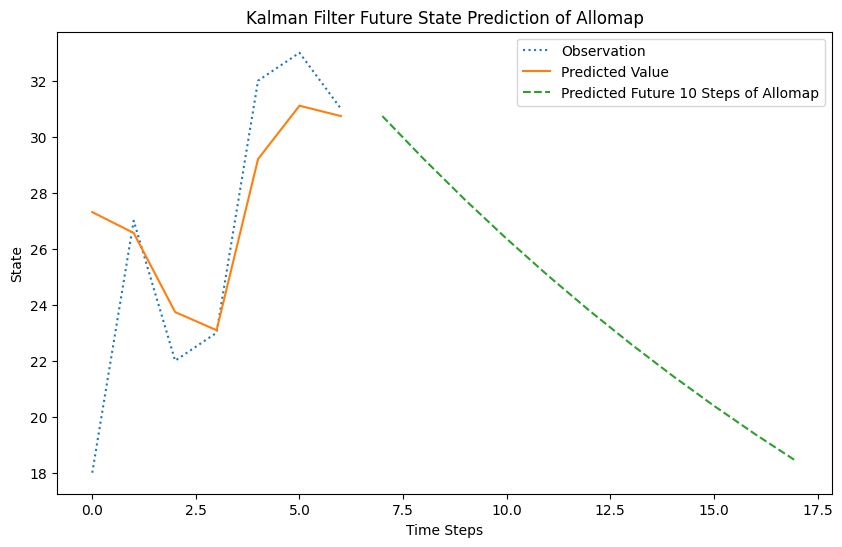

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(test_one.shape[0]), test_one[:, 0], label = "Observation", linestyle=':')
plt.plot(range(test_one.shape[0]), state_means[:, 0], label='Predicted Value')
plt.plot(range(test_one.shape[0], test_one.shape[0] + n_future_steps + 1), future_state_means[:, 0], label='Predicted Future 10 Steps of Allomap', linestyle='--')

plt.xlabel('Time Steps')
plt.ylabel('State')
plt.title('Kalman Filter Future State Prediction of Allomap')
plt.legend()
plt.show()

# Allosure

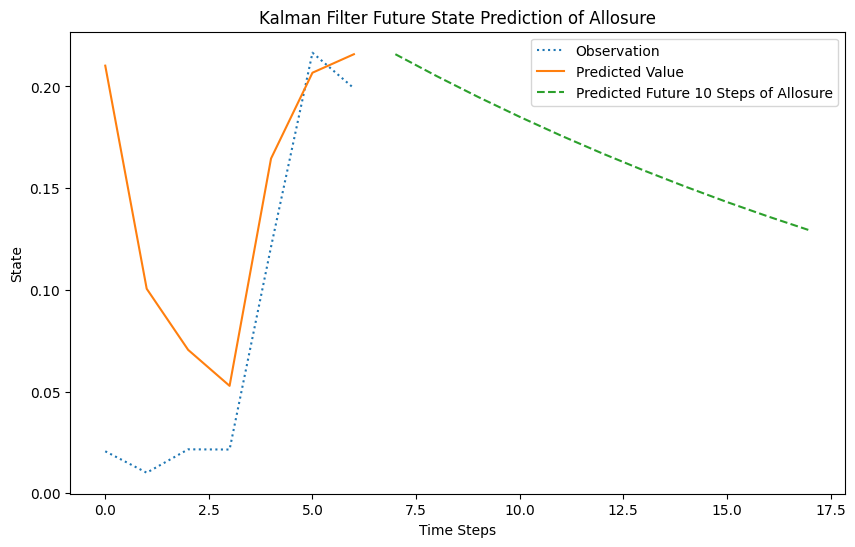

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(test_one.shape[0]), test_one[:, 1], label = "Observation", linestyle=':')
plt.plot(range(test_one.shape[0]), state_means[:, 1], label='Predicted Value')
plt.plot(range(test_one.shape[0], test_one.shape[0] + n_future_steps + 1), future_state_means[:, 1], label='Predicted Future 10 Steps of Allosure', linestyle='--')

plt.xlabel('Time Steps')
plt.ylabel('State')
plt.title('Kalman Filter Future State Prediction of Allosure')
plt.legend()
plt.show()

# predict one step future for multiple samples

In [11]:
# Assume X_test is an array where each row is a separate sample
state_means, state_covariances = kf.filter(X_test)
n_future_steps = 1

# Initialize lists to store predictions for all samples
future_state_means_list = []
future_state_covariances_list = []

for sample_index in range(X_test.shape[0]):
    # Get the last state mean and covariance for the current sample
    last_state_mean = state_means[sample_index] # This should be 1D or 2D
    last_state_covariance = state_covariances[sample_index]  # This should be 2D
        
    # Predict future state for this sample
    for step in range(n_future_steps):
        predicted_state_mean = kf.transition_matrices @ last_state_mean
        predicted_state_covariance = (
            kf.transition_matrices @ last_state_covariance @ kf.transition_matrices.T
            + kf.transition_covariance
        )
        
        # Update the last state for the next iteration (if predicting more than 1 step)
        last_state_mean = predicted_state_mean
        last_state_covariance = predicted_state_covariance
    
    # Store the prediction results for this sample
    future_state_means_list.append(predicted_state_mean.flatten())  # Flatten to make it 1D if needed
    future_state_covariances_list.append(predicted_state_covariance)

# Convert the lists to arrays for further processing or visualization
future_state_means = np.array(future_state_means_list)
future_state_covariances = np.array(future_state_covariances_list)

# The future_state_means array now contains the predicted future state for each sample in X_test


# Use current state to classify

In [12]:
# Use the state means for predictions
predicted_allosure = state_means[:, 1]
predicted_allomap = state_means[:, 0]

# Calculate predicted labels based on a threshold (e.g., 0.5)
predicted_labels = (predicted_allosure > 0.5).astype(int)
allosure_labels = (X_test[:, 1] > 0.5).astype(int)

# Calculate predicted labels based on the given thresholds
# The label will be 1 (positive) if both conditions are satisfied
# predicted_labels = np.where((predicted_allosure > 0.5) & (predicted_allomap > 30), 1, 0)


# Evaluate the performance
print("Classification Report:")
print(classification_report(y_test, predicted_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predicted_labels))

# Calculate predicted allosure AUC
auc = roc_auc_score(y_test, predicted_allosure)
print(f"predicted_AUC: {auc}")

# Calculate true allosure AUC
auc = roc_auc_score(y_test, X_test[:, 1])
print(f"baseline_AUC: {auc}")

accuracy = accuracy_score(y_test, predicted_labels)
print(f"kf Accuracy: {accuracy}")

accuracy = accuracy_score(y_test, allosure_labels)
print(f"baseline Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94      2114
         1.0       0.37      0.41      0.39       186

    accuracy                           0.90      2300
   macro avg       0.66      0.68      0.67      2300
weighted avg       0.90      0.90      0.90      2300

Confusion Matrix:
[[1983  131]
 [ 109   77]]
predicted_AUC: 0.7373017568488621
baseline_AUC: 0.7021139154230374
kf Accuracy: 0.8956521739130435
baseline Accuracy: 0.898695652173913


# Use future step for classification

In [13]:
# Use the state means for predictions
predicted_allosure = future_state_means[:, 1]
predicted_allomap = future_state_means[:, 0]

# Calculate predicted labels based on a threshold (e.g., 0.5)
predicted_labels = (predicted_allosure > 0.5).astype(int)
allosure_labels = (X_test[:, 1] > 0.5).astype(int)

# Calculate predicted labels based on the given thresholds
# The label will be 1 (positive) if both conditions are satisfied
# predicted_labels = np.where((predicted_allosure > 0.5) & (predicted_allomap > 30), 1, 0)


# Evaluate the performance
print("Classification Report:")
print(classification_report(y_test, predicted_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predicted_labels))

# Calculate predicted allosure AUC
auc = roc_auc_score(y_test, predicted_allosure)
print(f"predicted_AUC: {auc}")

# Calculate true allosure AUC
auc = roc_auc_score(y_test, X_test[:, 1])
print(f"baseline_AUC: {auc}")

accuracy = accuracy_score(y_test, predicted_labels)
print(f"kf Accuracy: {accuracy}")

accuracy = accuracy_score(y_test, allosure_labels)
print(f"baseline Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94      2114
         1.0       0.38      0.41      0.40       186

    accuracy                           0.90      2300
   macro avg       0.67      0.68      0.67      2300
weighted avg       0.90      0.90      0.90      2300

Confusion Matrix:
[[1990  124]
 [ 109   77]]
predicted_AUC: 0.7373017568488621
baseline_AUC: 0.7021139154230374
kf Accuracy: 0.898695652173913
baseline Accuracy: 0.898695652173913
